In [1]:
import os
import json
import numpy as np
import pandas as pd

from src.data_loader import Shifted_Data_Loader
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

Using TensorFlow backend.


See Notebook '05-Corrupted-labels' for details on training

In [2]:
np.random.seed(7)

In [3]:
corruption_fractions = np.round(np.linspace(0,1,11),decimals=1)
# idxs_corr = [np.random.choice(np.arange(60000),int(frac*60000),replace=False) for frac in corruption_fractions]
# y_tr = DL.y_train.copy()

In [4]:
# idxs_corr[3]

In [5]:
# n = 5

# list(filter(lambda v: v!=n,np.arange(10)) )


In [6]:
[np.arange(10)]*10

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [7]:
opt = [list(filter(lambda x: x!=n,np.arange(10).tolist())) for n in np.arange(10)]

In [8]:
np.random.choice(opt[0])

5

In [9]:
# y_corr_tr = []
# for idxs in idxs_corr[1:]:
#     y_corr = y_tr.copy()
#     curr_labels = DL.y_train[idxs]
#     new_labels = [np.random.choice(opt[l]) for l in curr_labels]
#     y_corr[idxs] = new_labels
#     y_corr_tr.append(y_corr)

In [10]:
# [len(y) for y in y_corr_tr]

In [11]:
# for y,frac in zip(y_corr_tr,corruption_fractions[1:]):
#     np.save('../data/fashion_mnist_corrupted_labels/y_train_{}'.format(np.round(frac,1)),y)

In [12]:
# for idxs,frac in zip(idxs_corr[1:],corruption_fractions[1:]):
#     np.save('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}'.format(np.round(frac,1)),idxs)

In [13]:
y_tr_idxs = [np.load('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
y_tr_corr = [np.load('../data/fashion_mnist_corrupted_labels/y_train_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
# y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)

In [14]:
def lowess_smooth(dat,time):
    filtered = lowess(dat, time, is_sorted=True,frac=0.01,it=1)
    return filtered

def sma(y,win_size):
    weights = np.repeat(1.0, win_size) / win_size
    yMA = np.convolve(y, weights, 'same')
    return yMA

def load_config(run_dir,filename='config.json'):
    path = os.path.join(run_dir,filename)
    if os.path.exists(path):
        with open(path,'r') as config_json:
            conf = json.load(config_json)
        return conf

def load_model_spec(run_dir,filename='model.json'):
    path = os.path.join(run_dir,filename)

    if os.path.exists(path):
        with open(path,'r') as model_json:
            mod_spec = json.load(model_json)
            
        return mod_spec

def load_train_history(run_dir,conf,filename='train_history.parquet'):
    path = os.path.join(run_dir,filename)
    dirname,fname = os.path.split(path)
#     lab_corruption = np.round(float(dirname.split('/')[-1].split('_')[-1]),decimals=1)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        hist = pd.read_parquet(path)
        hist['architecture'] = arch
        hist['label_corruption'] = conf['label_corruption']
        hist['ecc_max'] = conf['ecc_max']
        hist['epoch'] = list(hist.index.values)
#         hist['val_loss'] = sma(hist['val_loss'].values,win_size=3)
#         hist['loss'] = sma(hist['loss'].values,win_size=3)
        hist['val_dL'] = np.gradient(hist['val_loss'])
        hist['test_err'] = 1-hist['val_class_acc']
        hist['train_err'] = 1-hist['class_acc']
        hist['recon_gen_err'] = hist.G_loss - hist.val_G_loss
        hist['gen_err'] = hist.loss - hist.val_loss
        hist['class_gen_err'] = hist.class_loss - hist.val_class_loss
        hist['class_gen_acc'] = hist.class_acc - hist.val_class_acc

        return hist

def load_performance(run_dir, conf, th=None, filename='performance.json'):
    path = os.path.join(run_dir,filename)
#     dirname,fname = os.path.split(path)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        with open(path, 'rb') as json:
            
            perf = pd.read_json(json)
            perf['architecture'] = arch

            perf['test_err'] = 1-perf['test_acc']
        if th is not None:
            perf['test_acc_max'] = th['val_class_acc'].values.max()
            perf['tt_overfit'] = np.argmax(th['val_class_acc'].values)
            tt_mem_bin_vec = (th['class_acc'].values<= 1-conf['label_corruption']).astype(int)
            perf['tt_memorization'] = tt_mem_bin_vec.sum()
            perf['test_err_min'] = 1-perf['test_acc_max']
            perf['test_acc_auc'] = np.trapz(th['val_class_acc'])
            perf['test_loss_auc'] = np.trapz(th['val_class_loss'])
            perf['train_loss_auc'] = np.trapz(th['class_loss'])
        return perf

In [15]:
exp_root = '/home/elijahc/projects/vae/models/2019-04-02'
runs = []
for branches in os.listdir(exp_root):
    for leaf in os.listdir(os.path.join(exp_root,branches)):
        runs.append(os.path.join(exp_root,branches,leaf))
# recon_ecc_root = os.path.join(exp_root,'recon_and_ecc')
# recon_runs = [os.path.join(recon_root,d) for d in os.listdir(recon_root)]
# recon_runs.extend([os.path.join(recon_ecc_root,d) for d in os.listdir(recon_ecc_root)])
runs = list(filter(lambda x: 'ipynb_checkpoints' not in x,runs))
configs = [load_config(rd) for rd in runs]
train_historys = [load_train_history(rd,conf) for rd,conf in zip(runs,configs)]
perf = [load_performance(rd,conf,th) for rd,conf,th in zip(runs,configs,train_historys)]
model_specs = [load_model_spec(rd) for rd in runs]

# no_recon_root = os.path.join(exp_root,'no-recon')
# no_recon_runs = [os.path.join(no_recon_root,d) for d in os.listdir(no_recon_root)]
# no_recon_configs = 
# no_recon_train_historys = [load_train_history(rd,'no_recon') for rd in no_recon_runs]
# no_recon_perf = [load_performance(rd,'no_recon') for rd in no_recon_runs]

In [16]:
configs_df = pd.DataFrame.from_records(configs)

In [17]:
len(model_specs)

16

In [18]:
# len(configs_df.model_name)

In [19]:
configs_df.to_csv('../models/experiments/label_corruption_large_z/all_configs.csv')

In [20]:
hist_df = pd.concat(train_historys)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [21]:
hist_df.to_csv('../models/experiments/label_corruption_large_z/train_history_all.csv')

In [22]:
perf_df = pd.concat(perf)

In [23]:
perf_df.to_csv('../models/experiments/label_corruption_large_z/performance_summary_all.csv')

In [24]:
hist_df.head()

,G_generalization_error,G_loss,G_mse,architecture,class_acc,class_gen_acc,class_gen_err,class_generalization_error,class_loss,ecc_max,...,loss,recon_gen_err,test_err,train_err,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_dL,val_loss
0,-78.972694,167.585590,167.585590,recon,0.101433,-0.009233,0.058875,-0.058875,2.440939,0.8,...,4226.263253,78.972694,0.889333,0.898567,88.612896,88.612896,0.110667,2.382064,-193.405411,2251.062846
1,19.124646,61.667052,61.667052,recon,0.099550,-0.016117,-0.030141,0.030141,2.493560,0.8,...,1579.088984,-19.124646,0.884333,0.900450,80.791699,80.791699,0.115667,2.523701,-481.153935,2057.657434
2,4.383218,45.649512,45.649512,recon,0.113917,-0.023417,0.030554,-0.030554,2.559051,0.8,...,1179.632834,-4.383218,0.862667,0.886083,50.032729,50.032729,0.137333,2.528496,-473.421114,1288.754976
3,3.314644,39.712506,39.712506,recon,0.133450,-0.035883,0.239029,-0.239029,2.580839,0.8,...,1031.534496,-3.314644,0.830667,0.866550,43.027151,43.027151,0.169333,2.341810,19.458881,1110.815206
4,15.004531,36.701410,36.701410,recon,0.141617,-0.027383,0.243409,-0.243409,2.577747,0.8,...,956.210649,-15.004531,0.831000,0.858383,51.705941,51.705941,0.169000,2.334338,-116.613086,1327.672738


In [25]:
# sns.scatterplot(data=hist_df[['val_class_acc','class_acc']].query('architecture = "recon"'))

In [26]:
def train_plot(metric,filts={'ecc_max':0.0,'architecture':'no_recon'},pop_out_legend=True,legend='full'):
    pd_query = []
    for k in filts.keys():
        if isinstance(filts[k],str):
            qs = "{} == '{}'".format(k,filts[k])
        else:
            qs = "{} == {}".format(k,filts[k])
        
        pd_query.append(qs)
        
    if legend is not None and pop_out_legend:
        fig_size = (8,5)
    else:
        fig_size = (5,5)
    
    fig,ax = plt.subplots(1,1,figsize=fig_size)
    
    sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df.query(' & '.join(pd_query)),legend=legend,ax=ax)
    
    if legend is not None and pop_out_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    return fig

In [27]:
def recon_ecc_grid(metric='class_acc',sharey=True,sharex=True,subplot_kw=None,leg='full'):
    archs = ['no_recon','recon']
    filts = [hist_df.architecture == a for a in archs]

    fig,axs = plt.subplots(2,2,figsize=(10,10),
                           sharey=sharey,
                           sharex=sharex,
                           subplot_kw=subplot_kw,
                          )
    for filt,i in zip(filts,np.arange(2)):
        if i == 0:
            leg = leg
        else:
            leg = None
        if len(hist_df[filt]) > 0:
            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#             axs[i,0].set_yscale(yscale)
            axs[i,0].set_title('ecc: 0.0')

            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
            axs[i,1].set_title('ecc: 0.8')
    #         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    
    return fig

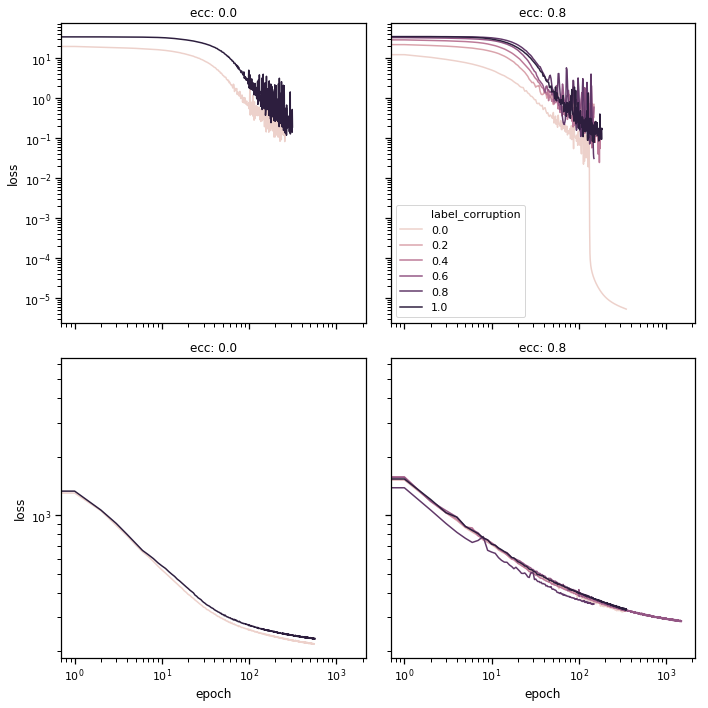

In [28]:
sns.set_context('notebook')
fig = recon_ecc_grid(metric='loss',sharey='row',
                    subplot_kw={
                         'yscale':'log',
                         'xscale':'log'
                    })

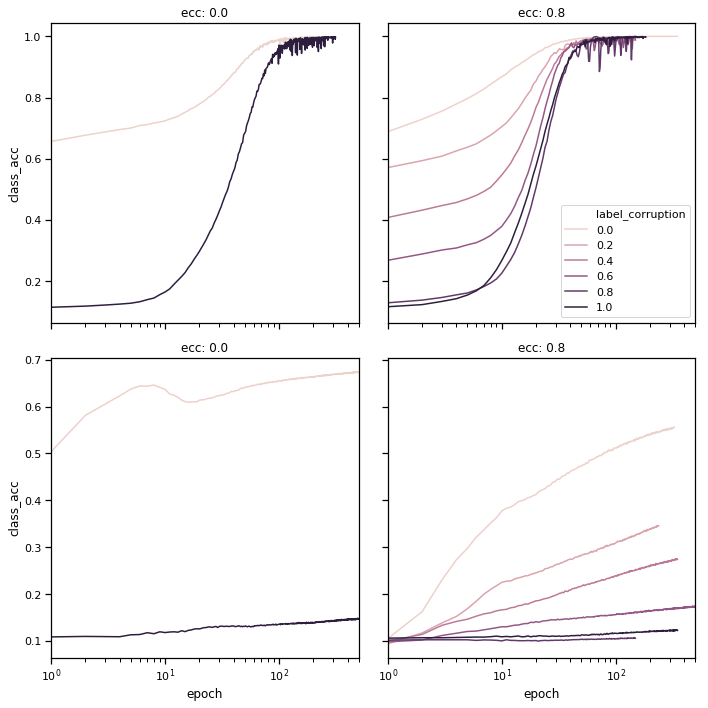

In [29]:
fig = recon_ecc_grid(metric='class_acc',sharey='row',
                     subplot_kw={
#                          'yscale':'log',
                         'xscale':'log',
                         'xlim':(1,500)
                     })

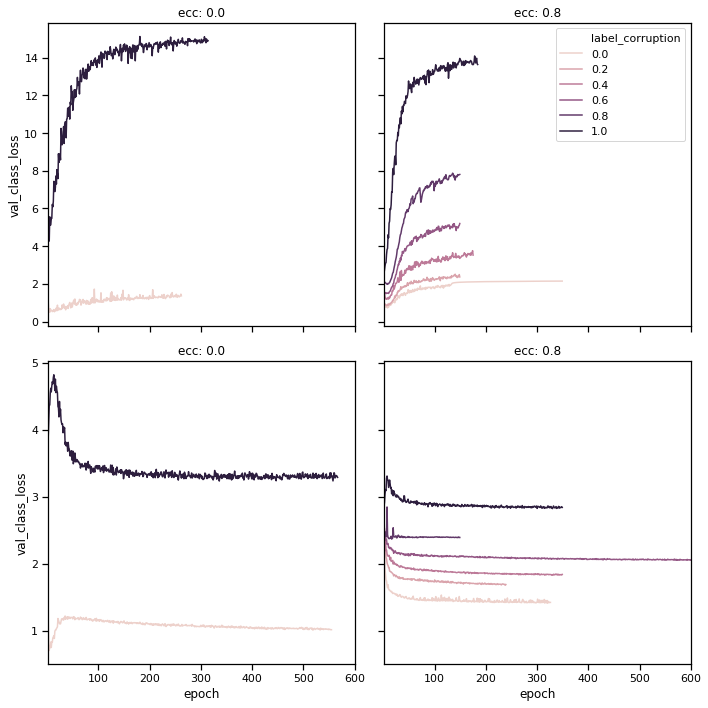

In [30]:
sns.set_context('notebook')
fig = recon_ecc_grid(metric='val_class_loss',sharey='row',
                    subplot_kw={
#                          'yscale':'log',
#                          'xscale':'log',
                        'xlim':(1,600)
                    })

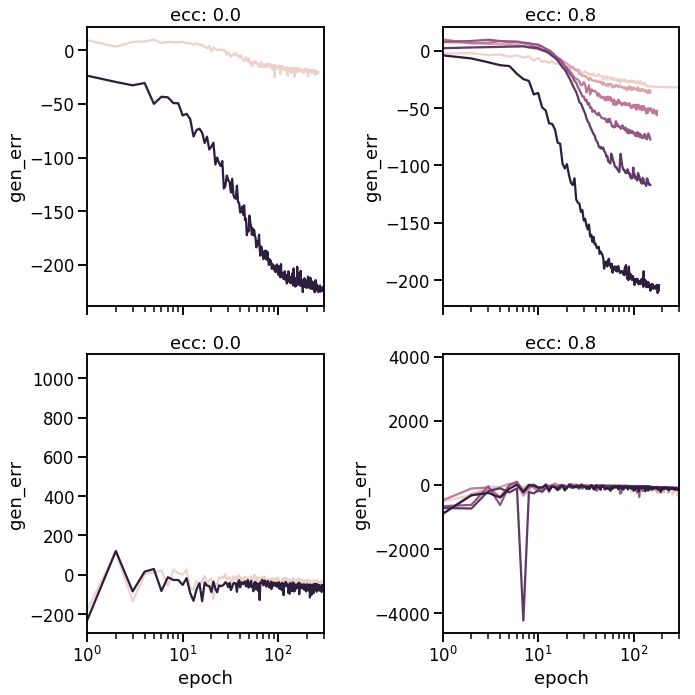

In [49]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='gen_err',
                     subplot_kw={
                         'xscale':'log',
                         'xlim':(1,300)
                     },sharey=False,leg=None)

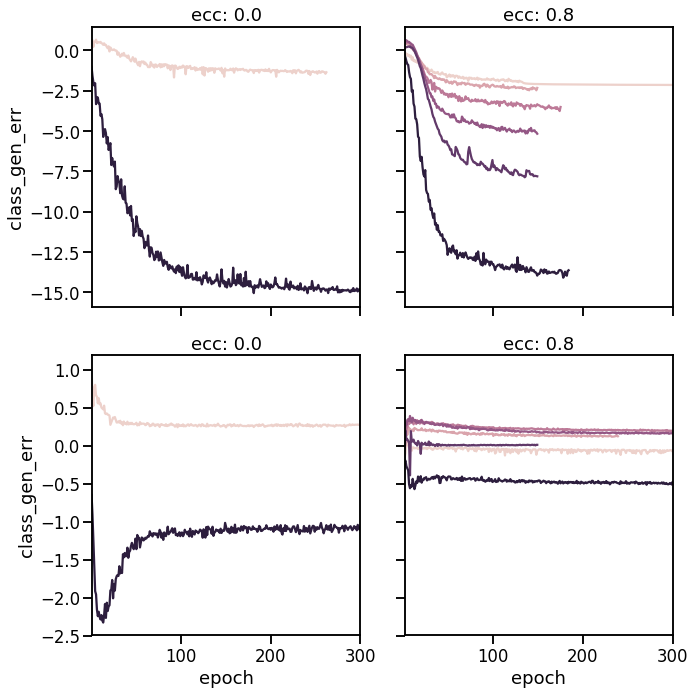

In [50]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='class_gen_err',
                     subplot_kw={
#                          'xscale':'log',
                         'xlim':(1,300)
                     },sharey='row',leg=None)

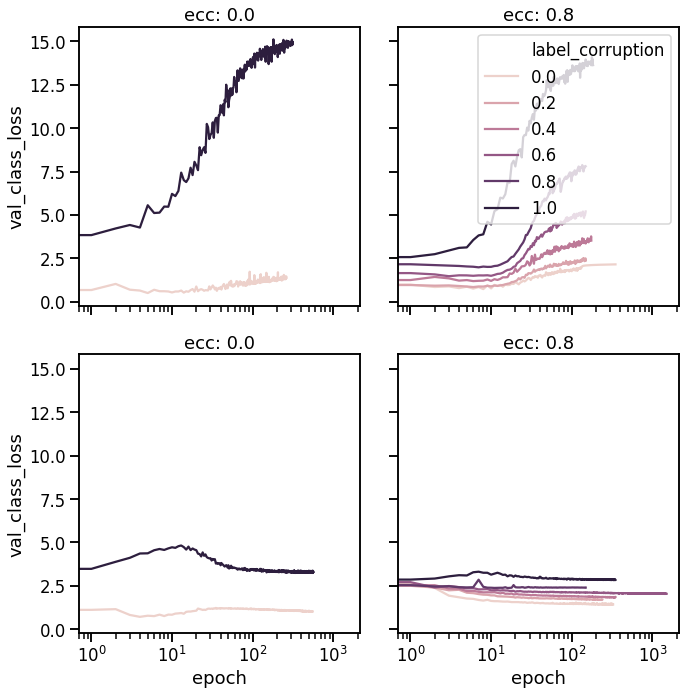

In [53]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='val_class_loss',subplot_kw={'xscale':'log'},sharey=True)

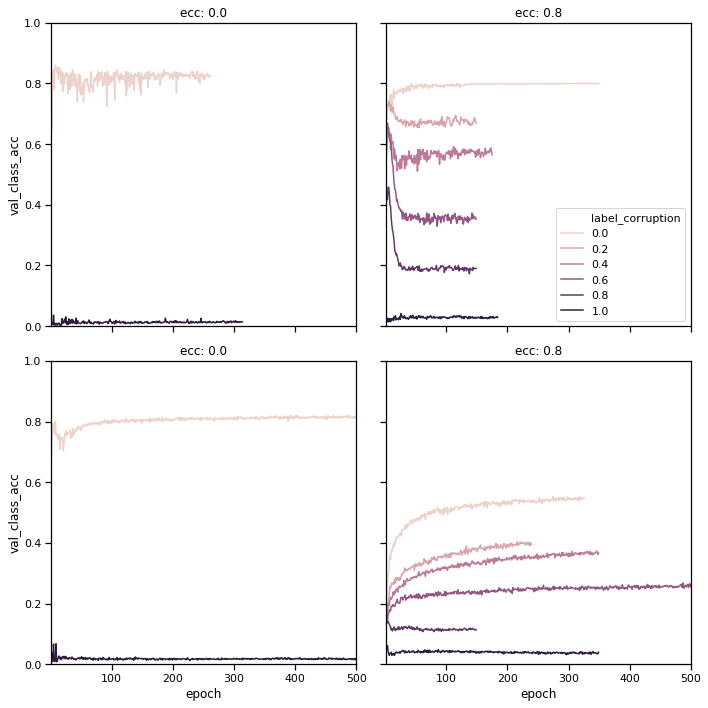

In [51]:
sns.set_context('notebook')
fig = recon_ecc_grid(metric='val_class_acc',
                     subplot_kw={
#                          'xscale':'log',
                         'xlim':(1,500),
                         'ylim':(0,1),
                     },sharey=True)

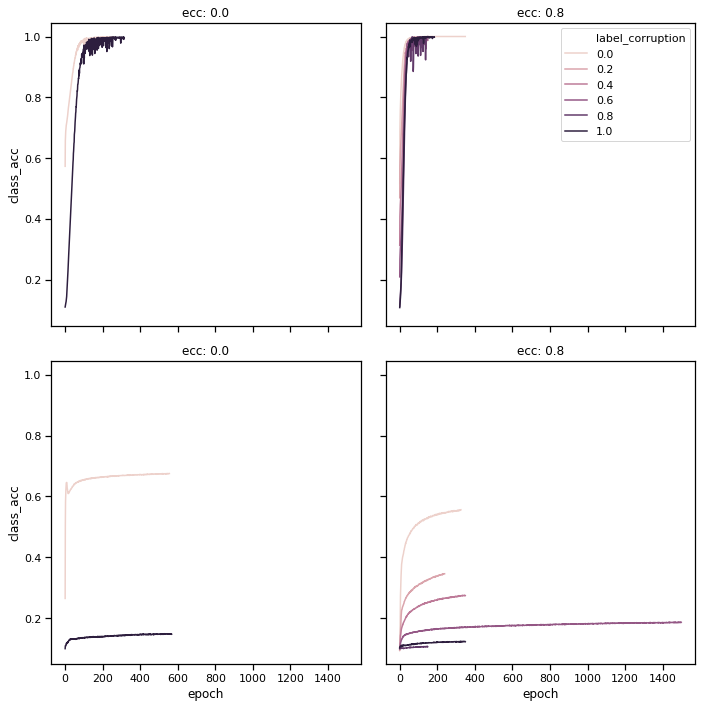

In [35]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                      )
sns.set_context('notebook')
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0')
        
        sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
        axs[i,1].set_title('ecc: 0.8')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/train_acc.png',dpi=150)

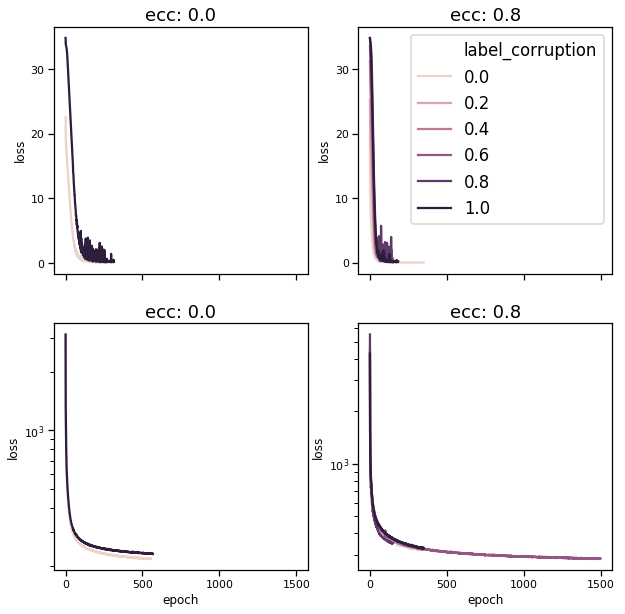

In [36]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
#                        sharey=True,
                       sharex=True,
                      )
sns.set_context('talk')
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        axs[1,i].set_yscale('log')
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0')
        
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
        axs[i,1].set_title('ecc: 0.8')

In [37]:
def corruption_plot(x,y,hue,hue_order=None,style=None,data=None,legend=None,palette=None,ax=None):
    g = sns.lineplot(x=x,y=y,hue=hue,hue_order=hue_order,style=style,
                 data=data,legend=legend,palette=palette,ax=ax)
    if legend is not None:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return g

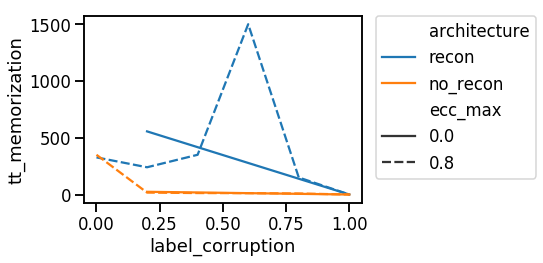

In [38]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',ax=ax)
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/tt_memorization.png',dpi=150)

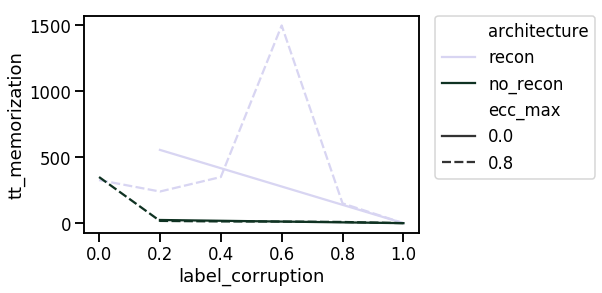

In [39]:
sns.set_context('talk')
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',palette=sns.cubehelix_palette(2,start=5))
# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)


# axs[0].set_title('no_recon')

# g = sns.lineplot(x='label_corruption',y='tt_memorization',hue='ecc_max',hue_order=[0,0.8],
#                  data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))
# axs[1].set_title('recon')
# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

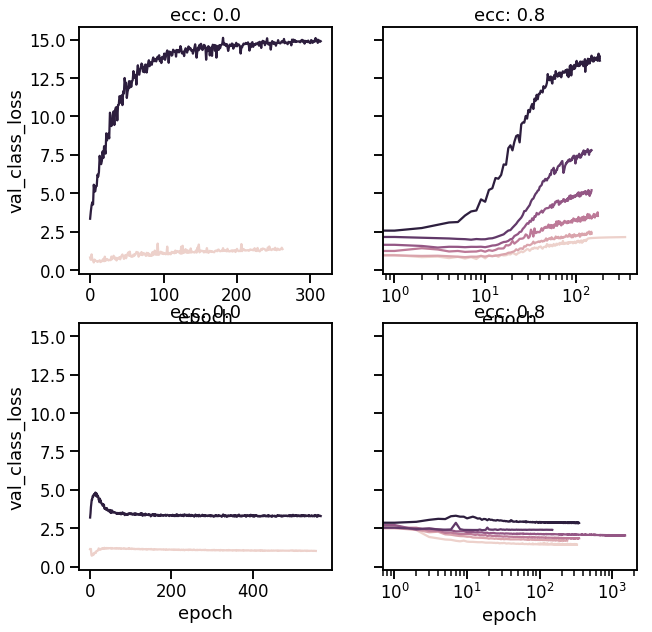

In [40]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
#                        sharex=True,
                      )
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='val_class_loss',hue='label_corruption',hue_order=sorted(corruption_fractions[1:]),
                     data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0',)
        
        sns.lineplot(x='epoch',y='val_class_loss',hue='label_corruption',hue_order=sorted(corruption_fractions[1:]),
                     data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=None)
        axs[i,1].set_title('ecc: 0.8')
        axs[i,1].set_xscale('log')
        
fig.savefig('../figures/label_corruption_sweeps/val_class_loss.png',dpi=150)

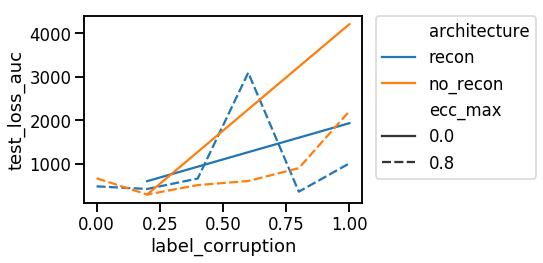

In [41]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='test_loss_auc',hue='architecture',style='ecc_max',data=perf_df,legend='full')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc.png',dpi=150)

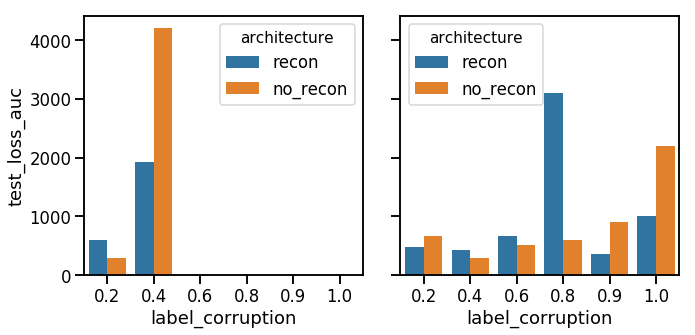

In [42]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.0'),ax=axs[0])
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.8'),ax=axs[1])
# g.set(legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_ylabel('')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc_barplot.png',dpi=150)

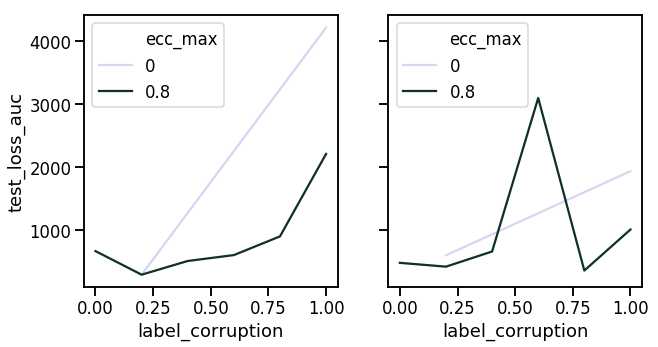

In [43]:

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "no_recon"'),legend='full',ax=axs[0],palette=sns.cubehelix_palette(2,start=5))
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))

# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

In [44]:
# sns.set_context('talk')

# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'], data=perf_df.query('ecc_max == "0.0"'),legend='full',ax=axs[0])
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'],data=perf_df.query('ecc_max == "0.8"'),legend='full',ax=axs[1])

# # plt.ylim(0,1.1)
# # plt.xlim(0,1.1)

In [45]:
sns.cubehelix_palette(6)

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8559578605899612, 0.6418993116910497, 0.6754191211563135],
 [0.739734329496642, 0.4765280683170713, 0.5959617419736206],
 [0.57916573903086, 0.33934576125314425, 0.5219003947563425],
 [0.37894937987024996, 0.2224702044652721, 0.41140014301575434],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

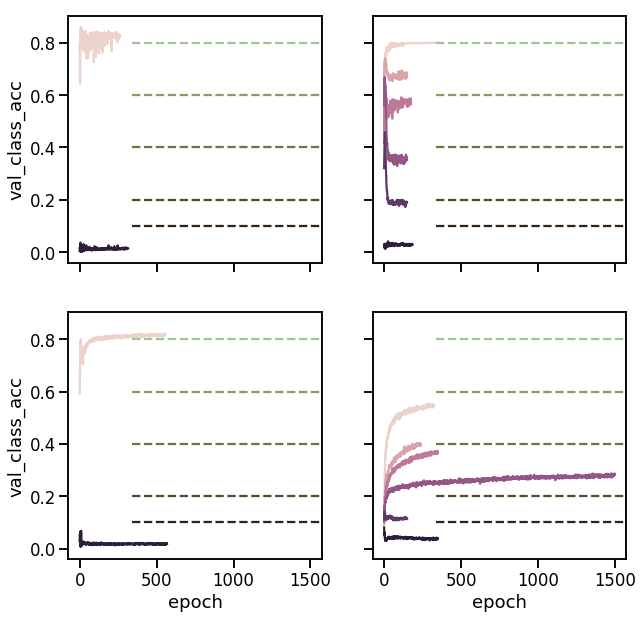

In [46]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                      )
for filt,i in zip(filts,np.arange(2)):
    if i == 1:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#         axs[i,0].set_title('no_recon')
        
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=None)
#         axs[i,1].set_title('recon')
        for c,chance in zip(sns.cubehelix_palette(6,reverse=True,start=1),[0.1,0.2,0.4,0.6,0.8]): 
            axs[i,0].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            axs[i,1].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            
fig.savefig('../figures/label_corruption_sweeps/val_class_acc.png',dpi=150)